In [1]:
library(tidyverse)

library(grid)
library(gridExtra)
library(patchwork)

source("../evaluation_utils/plots_eda.R")
source("../evaluation_utils/evaluation_funcs.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: viridisLite

Loading required package: limma

Loading required package: BiocParallel


Attaching package: ‘variancePartition’


The following object is masked from ‘package:limma’:

    topTable




In [2]:
# R version
R.version.string

[1] "R version 4.3.3 (2024-02-29)"

In [3]:
cbPalette <- c("#CC79A7", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00")

# Load data

In [4]:
path_to_data <- "../evaluation_data/simulated/"
n_runs <- 30


In [19]:
for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced")){
    differences_table <- data.frame(
        min = numeric(),
        max = numeric(),
        mean = numeric(),
        mean_sd = numeric()
    )
    # error_expr_levels_table <- data.frame(
    #     min = numeric(),
    #     max = numeric(),
    #     mean = numeric()
    # )

    print(paste0("Processing mode: ", mode))

    metadata <- read.csv(paste0(path_to_data, mode, "/all_metadata.tsv"), sep = "\t") %>%
        as.data.frame()
    rownames(metadata) <- metadata$file

    for(j in 1:n_runs){
        fedsim_results <- read.csv(
                paste0(path_to_data, mode, "/after/runs/", j, "_FedSim_corrected.tsv"), 
                sep = "\t") %>%
            as.data.frame() %>% column_to_rownames("rowname")
        fedsim_results <- fedsim_results[, metadata$file]

        r_corrected <- read.csv(
                paste0(path_to_data, mode, "/after/runs/", j, "_R_corrected.tsv"), 
                sep = "\t") %>%
            as.data.frame() %>% column_to_rownames("rowname")

        # if size of r_corrected is different from fedsim_results, print a warning
        if(nrow(r_corrected) != nrow(fedsim_results)){
            print(paste0("Warning: size of R_corrected is different from FedSim_corrected for run ", j))
        } else if (ncol(r_corrected) != ncol(fedsim_results)){
            print(paste0("Warning: number of samples in R_corrected is different from FedSim_corrected for run ", j))
        }
        
        r_corrected <- r_corrected[, metadata$file]
        fedsim_results <- fedsim_results[rownames(r_corrected), colnames(r_corrected)]

        # calcualte differences
        differences <- as.matrix(abs(r_corrected - fedsim_results))
        min_max_mean <- c(min(differences, na.rm = TRUE), max(differences, na.rm = TRUE), mean(differences, na.rm = TRUE))
        # sd for mean values
        sd_value <- sd(differences, na.rm = TRUE)
        differences_table[j, ] <- c(min_max_mean, sd_value)

        # # differences divided by expression level in r_corrected
        # error_expr_levels <- abs(differences * 100 / as.matrix(r_corrected))
        # min_max_mean_expr_levels <- c(min(error_expr_levels, na.rm = TRUE), 
        #                               max(error_expr_levels, na.rm = TRUE), 
        #                               mean(error_expr_levels, na.rm = TRUE))
        # error_expr_levels_table[j, ] <- min_max_mean_expr_levels

        
        # form <- ~ condition + lab
        # # calculate after correction LMPV
        # after_correction_lmpv <- lmpv_plot(fedsim_results, metadata, 
        #                                    form = form, only_table = TRUE)
        # # write to file
        # write.table(after_correction_lmpv, 
        #             paste0("eval_simulation/", mode, "/lmvp/", j, "_after_correction_lmpv.tsv"),
        #             sep = "\t", quote = FALSE, row.names = FALSE)
    }

    # write differences to file with max, min, mean colnames
    write.table(differences_table %>% rownames_to_column("run"),
                paste0("eval_simulation/", mode, "/differences_fedRBE_R.tsv"),
                sep = "\t", quote = FALSE, row.names = FALSE)

    # # write differences to file with max, min, mean colnames
    # write.table(error_expr_levels_table %>% rownames_to_column("run"),
    #             paste0("eval_simulation/", mode, "/error_expr_levels_fedRBE_R.tsv"),
    #             sep = "\t", quote = FALSE, row.names = FALSE)
}

error calcualtion but faster

In [10]:
library(data.table)
library(parallel)

# Cache metadata once for all modes
metadata_list <- lapply(c("balanced", "mild_imbalanced", "strong_imbalanced"), function(mode) {
  metadata <- fread(paste0(path_to_data, mode, "/all_metadata.tsv"), sep = "\t")
  
  # Handle unexpected columns in the metadata
  expected_columns <- 3  # Assuming you expect 3 columns
  if (ncol(metadata) > expected_columns) {
    warning(paste0("Detected ", ncol(metadata), " columns; expected ", expected_columns, ". Adjusting..."))
    metadata <- metadata[, .SD, .SDcols = 2:(expected_columns + 1)]  # Adjust column selection as needed
  }
  
  setDT(metadata, key = "file")
  list(mode = mode, metadata = metadata)
})

for (metadata_info in metadata_list) {
  mode <- metadata_info$mode
  metadata <- metadata_info$metadata
  
  differences_table <- data.frame(
    min = numeric(n_runs),
    max = numeric(n_runs),
    mean = numeric(n_runs),
    mean_sd = numeric(n_runs)
  )
  
  print(paste0("Processing mode: ", mode))

  # Parallelize the loop over runs
  results <- mclapply(1:n_runs, function(j) {
    fedsim_path <- paste0(path_to_data, mode, "/after/runs/", j, "_FedSim_corrected.tsv")
    r_corrected_path <- paste0(path_to_data, mode, "/after/runs/", j, "_R_corrected.tsv")
    
    # Read FedSim and R-corrected files
    fedsim_results <- fread(fedsim_path, sep = "\t")
    r_corrected <- fread(r_corrected_path, sep = "\t")

    # Check for size mismatch
    if (nrow(r_corrected) != nrow(fedsim_results) || ncol(r_corrected) != ncol(fedsim_results)) {
      warning(paste0("Size mismatch for run ", j, " in mode ", mode))
      return(NULL)
    }

    # Align column and row order
    setkeyv(r_corrected, "rowname")
    setkeyv(fedsim_results, "rowname")
    fedsim_results <- fedsim_results[, metadata$file, with = FALSE]
    r_corrected <- r_corrected[, metadata$file, with = FALSE]
    
    # Calculate differences
    differences <- abs(as.matrix(r_corrected) - as.matrix(fedsim_results))
    c(min(differences, na.rm = TRUE), 
      max(differences, na.rm = TRUE), 
      mean(differences, na.rm = TRUE), 
      sd(differences, na.rm = TRUE))
  }, mc.cores = 5)

  # Combine results and write to output
  differences_table <- do.call(rbind, results)
  # add colnames
  colnames(differences_table) <- c("min", "max", "mean", "mean_sd")
  output_path <- paste0("eval_simulation/", mode, "/differences_fedRBE_R.tsv")
  fwrite(data.frame(run = 1:n_runs, differences_table), output_path, sep = "\t")
}


Warning message in fread(paste0(path_to_data, mode, "/all_metadata.tsv"), sep = "\t"):
“Detected 3 column names but the data has 4 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in FUN(X[[i]], ...):
“Detected 4 columns; expected 3. Adjusting...”
Warning message in fread(paste0(path_to_data, mode, "/all_metadata.tsv"), sep = "\t"):
“Detected 3 column names but the data has 4 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in FUN(X[[i]], ...):
“Detected 4 columns; expected 3. Adjusting...”
Warning message in fread(paste0(path_to_data

[1] "Processing mode: balanced"
[1] "Processing mode: mild_imbalanced"
[1] "Processing mode: strong_imbalanced"


before correctuin lmpv

In [52]:
for(mode in c(
    "balanced",  "mild_imbalanced", "strong_imbalanced"
)){
    print(paste0("Processing mode: ", mode))

    metadata <- read.csv(paste0(path_to_data, mode, "/all_metadata.tsv"), sep = "\t") %>%
        as.data.frame()
    rownames(metadata) <- metadata$file

    for(j in 1:n_runs){
        before_corr <- read.csv(
                paste0(path_to_data, mode, "/before/intermediate/", j, "_intensities_data.tsv"), 
                sep = "\t") %>%
            as.data.frame() %>% column_to_rownames("rowname")
        before_corr <- before_corr[, metadata$file]


        form <- ~ condition + lab
        # calculate after correction LMPV
        before_correction_lmpv <- lmpv_plot(before_corr, metadata, 
                                           form = form, only_table = TRUE)
        # write to file
        write.table(before_correction_lmpv, 
                    paste0("eval_simulation/", mode, "/lmvp/", j, "_before_correction_lmpv.tsv"),
                    sep = "\t", quote = FALSE, row.names = FALSE)
    }
}

[1] "Processing mode: balanced"
[1] "Processing mode: mild_imbalanced"
[1] "Processing mode: strong_imbalanced"


# Evaluation errors

In [46]:
library(tidyverse)

[1] "Processing mode: balanced"
[1] "Processing mode: mild_imbalanced"
[1] "Processing mode: strong_imbalanced"


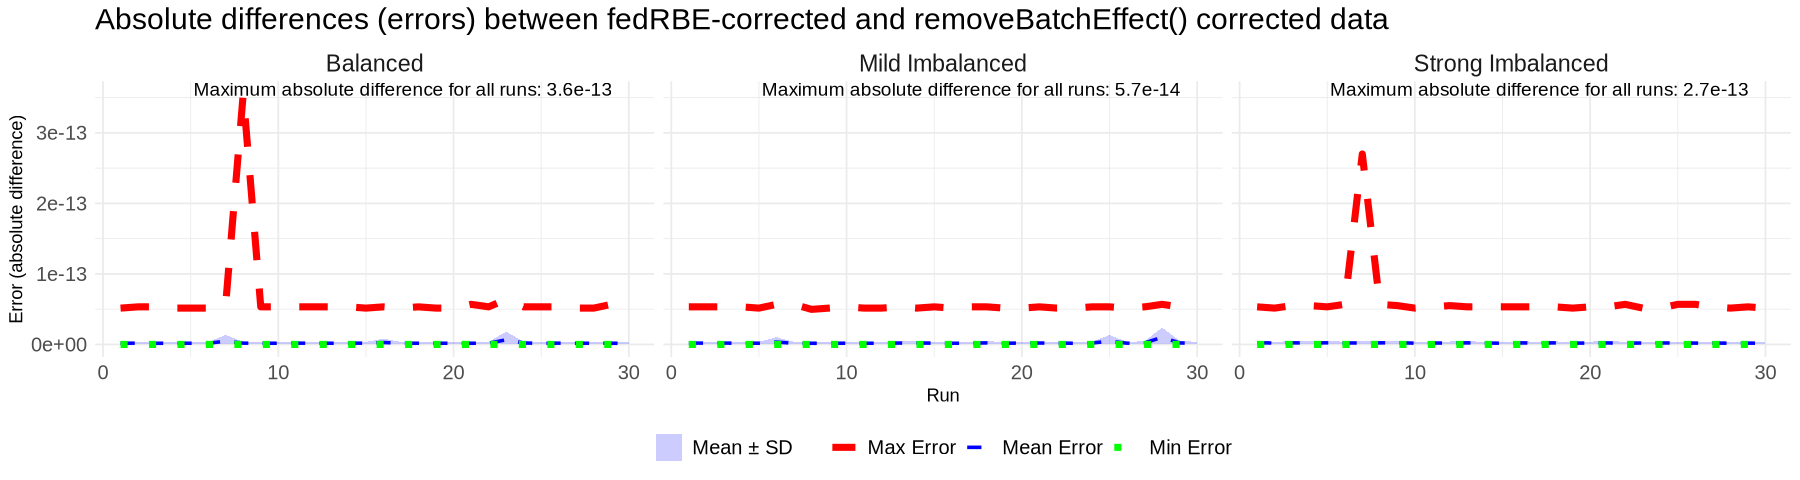

In [52]:
library(ggplot2)
library(dplyr)

# List of modes to iterate over
modes <- c("balanced", "mild_imbalanced", "strong_imbalanced")
combined_df <- data.frame() # Initialize an empty data frame for combining data

# Read and combine data for all modes
for (mode in modes) {
    print(paste0("Processing mode: ", mode))
    errors_df <- read.table(paste0("eval_simulation/", mode, "/differences_fedRBE_R.tsv"), sep = "\t", header = TRUE)
    errors_df$mode <- ifelse(mode == "balanced", "Balanced", ifelse(mode == "mild_imbalanced", "Mild Imbalanced", "Strong Imbalanced")) # Add a column for the mode
    combined_df <- rbind(combined_df, errors_df) # Combine data
}

# Calculate the maximum value for each mode
max_values_df <- combined_df %>% 
    group_by(mode) %>% 
    summarise(max_value = max(max, na.rm = TRUE))

# Merge the max values back into the combined dataframe for plotting
combined_df <- combined_df %>% 
    left_join(max_values_df, by = "mode")

options(repr.plot.width = 15, repr.plot.height = 4, dpi = 600)
# Plotting using ggplot2
ggplot(combined_df, aes(x = run)) +
    geom_ribbon(aes(ymin = pmax(0, mean - mean_sd), ymax = mean + mean_sd, fill = "Mean ± SD"), alpha = 0.2) +
    geom_line(aes(y = mean, color = "Mean Error"), size = 1, linetype = "dashed") +
    geom_line(aes(y = max, color = "Max Error"), size = 2, linetype = "dashed") +
    geom_line(aes(y = min, color = "Min Error"), size = 2, linetype = "dotted") +
    facet_wrap(~ mode, nrow = 1, scales = "fixed") + # One row, fixed y-axis
    geom_text(data = max_values_df, 
          aes(x = Inf, y = Inf, label = paste0("Maximum absolute difference for all runs: ", scales::scientific(max_value, digits = 2))), 
          hjust = 1.1, vjust = 1.1, size = 4, color = "black") +
    labs(
        title = "Absolute differences (errors) between fedRBE-corrected and removeBatchEffect() corrected data",
        x = "Run",
        y = "Error (absolute difference)"
    ) +
    scale_color_manual(values = c("Max Error" = "red", "Mean Error" = "blue", "Min Error" = "green")) +
    scale_fill_manual(values = c("Mean ± SD" = "blue")) + # Color for the shaded area
    theme_minimal() +
    theme(
        strip.text = element_text(size = 14), # Make mode names larger and bold
        axis.text.x = element_text(size = 12), # Make x-axis labels larger
        axis.text.y = element_text(size = 12), # Make y-axis labels larger
        plot.title = element_text(size = 18), # Make plot title larger
        # make legend text larger
        legend.text = element_text(size = 12),
        legend.title = element_blank(),
        legend.position = "bottom" # Adjust legend position for clarity
    )


In [4]:
library(ggplot2)
library(dplyr)

# List of modes to iterate over
modes <- c("balanced", "mild_imbalanced", "strong_imbalanced")
combined_df <- data.frame() # Initialize an empty data frame for combining data

# Read and combine data for all modes
for (mode in modes) {
    print(paste0("Processing mode: ", mode))
    errors_df <- read.table(paste0("eval_simulation/", mode, "/differences_fedRBE_R.tsv"), sep = "\t", header = TRUE)
    errors_df$mode <- ifelse(mode == "balanced", "Balanced", ifelse(mode == "mild_imbalanced", "Mild Imbalanced", "Strong Imbalanced")) # Add a column for the mode
    combined_df <- rbind(combined_df, errors_df) # Combine data
}

# Calculate the maximum value for each mode
mean_values_df <- combined_df %>% 
    group_by(mode) %>% 
    summarise(mean_value = mean(mean, na.rm = TRUE),
              max_value = max(max, na.rm = TRUE))

mean_values_df

[1] "Processing mode: balanced"
[1] "Processing mode: mild_imbalanced"
[1] "Processing mode: strong_imbalanced"


mode,mean_value,max_value
<chr>,<dbl>,<dbl>
Balanced,2.018134e-15,3.552714e-13
Mild Imbalanced,2.255777e-15,5.684342e-14
Strong Imbalanced,2.035043e-15,2.700062e-13
